![my image caption](Network_ball_hero.jpg)

# How can the company improve collaboration?

## 📖 Background
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company. 

## Key findings : 

Based on the number of messages sent, the most active departments are, in descending order:
- Sales France
- US Operations
- Administration France
- US Sales
- US administration

Using the same metric , the least active departments are , in increasing order:
- Brazil Engineering
- IT Brazil
- Engineering France
- US Marketing
- German engineering

The most connected employee, based on the number of unique connections (messages sent and received) has the ID number 598 and is in the US Operation department.
He is followed by:
- the employee with the ID 144, from the US sales department.
- the employee with ID 128, from the French sales department.
- the employee with ID 605, from the Administration France department.
- the employee with ID 586, from the French operations department.

The most influential departments, based on betweenness centrality, which measures which entities are 'bridges' between other entities in a network (in graph theory) , are:
- US Admin Department
- The French Sales department
- The US operations department
- The US Sales Department
- The French operations 

## Recommandations : 

This report suggests that :
- The departments of some countries, such as the UK and Brazil, communicate very little compared to others , such as those of the US and France.
- Without taking into account the country of origin, the IT, Engineering and (surprisingly) Marketing departments communicate very little, and receive many more messages than they send. 

It could be profitable, for human resources, to increase their efforts on these two directions.

In [9]:
# Data manipulation
import pandas as pd , numpy as np

# Data visualisation
import matplotlib.pyplot as plt , seaborn as sns

# Network analysis
import networkx as nx 

# Set a random seed
np.random.seed(23)

In [10]:
# Load and inspect the data
messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])
employees = pd.read_csv('data/employees.csv')
print('Message: \n' , messages.head(1))
print('Employee: \n' , employees.head(1))

Message: 
    sender  receiver           timestamp  message_length
0      79        48 2021-06-02 05:41:34              88
Employee: 
    id  department location  age
0   3  Operations       US   33


## Network graph : 

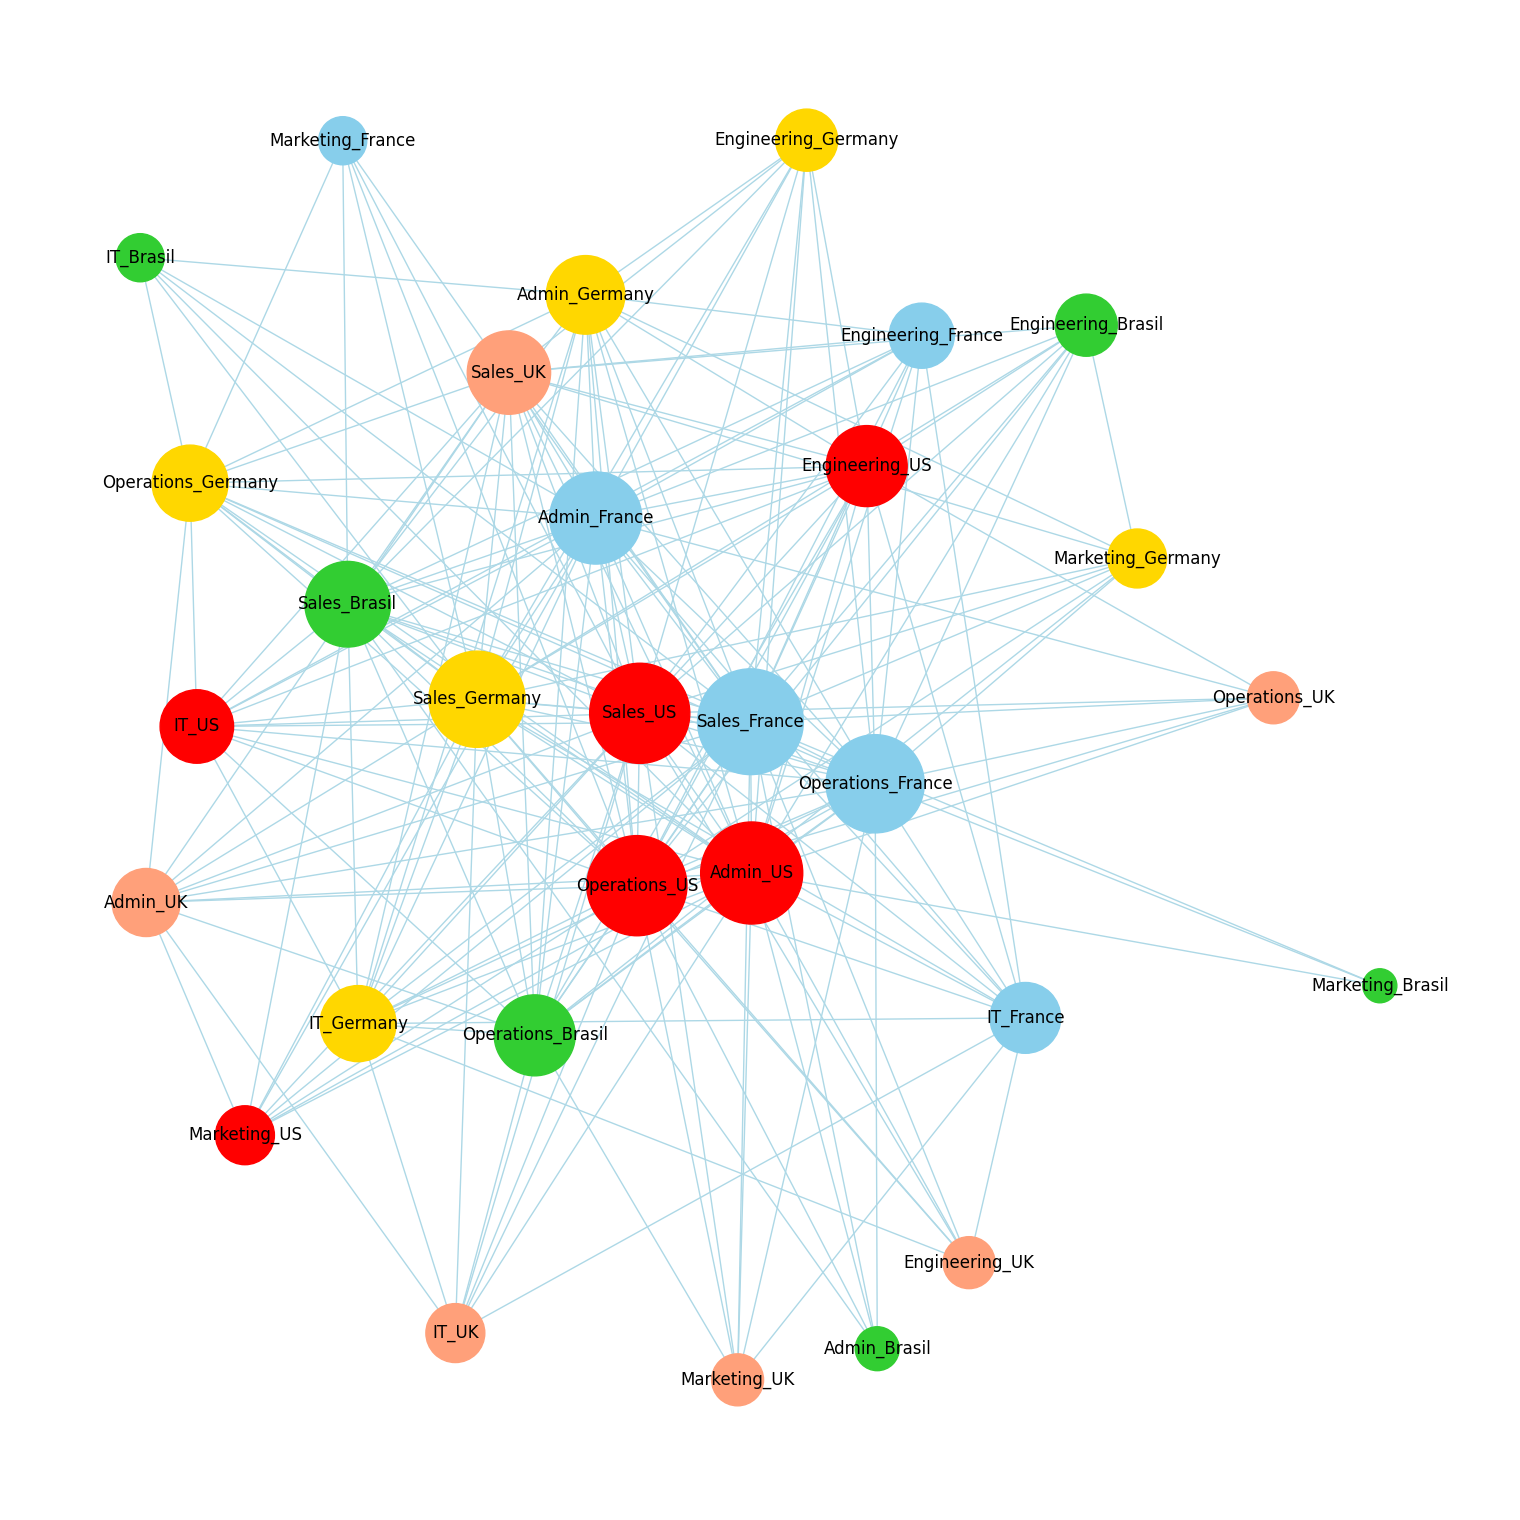

In [11]:
# Build the network
merged = employees.merge(messages , left_on='id' , right_on='sender')
merged.drop(['message_length' , 'ID' , 'id' , 'timestamp' , 'age'] , axis=1 , inplace=True , errors='ignore')
merged = merged.merge(employees[['id' , 'location' , 'department']] , left_on='receiver' , right_on='id' , how='inner').drop(['sender' , 'receiver' , 'id'] , axis=1)
merged.columns = ['department_s' , 'location_s' , 'location_r' , 'department_r']
merged = merged[['department_s', 'location_s', 'department_r' , 'location_r']]
g = nx.from_pandas_edgelist(merged , 'department_s' , 'department_r' , edge_attr=['location_s' , 'location_r'] , create_using=nx.DiGraph())
merged['value'] = 1
merged = merged.groupby(['department_s',	'location_s',	'department_r',	'location_r'] , as_index=False , sort=False).sum()
merged['entity_s'] = merged['department_s'] + '_' + merged['location_s']
merged['entity_r'] = merged['department_r'] + '_' + merged['location_r']
merged = merged[['entity_s' , 'entity_r' , 'value']]


G = nx.from_pandas_edgelist(merged , source='entity_s',
                                    target='entity_r',
                                    edge_attr='value',
                                    create_using=nx.Graph())

colors = []
for node in G:
    if node.split('_')[1] == 'France':
       colors.append('skyblue')
    elif node.split('_')[1] == 'US':
        colors.append('red')
    elif node.split('_')[1] == 'UK':    
        colors.append('lightsalmon')
    elif node.split('_')[1] == 'Brasil':
        colors.append('limegreen')
    elif node.split('_')[1] == 'Germany':
        colors.append('gold')
        


G.remove_edges_from(nx.selfloop_edges(G))
degrees = dict(G.degree)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(15,15))
nx.draw(G , with_labels=True , pos = pos  , edge_color='lightblue' , node_size=[v * 200 for v in dict(G.degree()).values()]  , node_color=colors)

## Betweenness Centrality : 

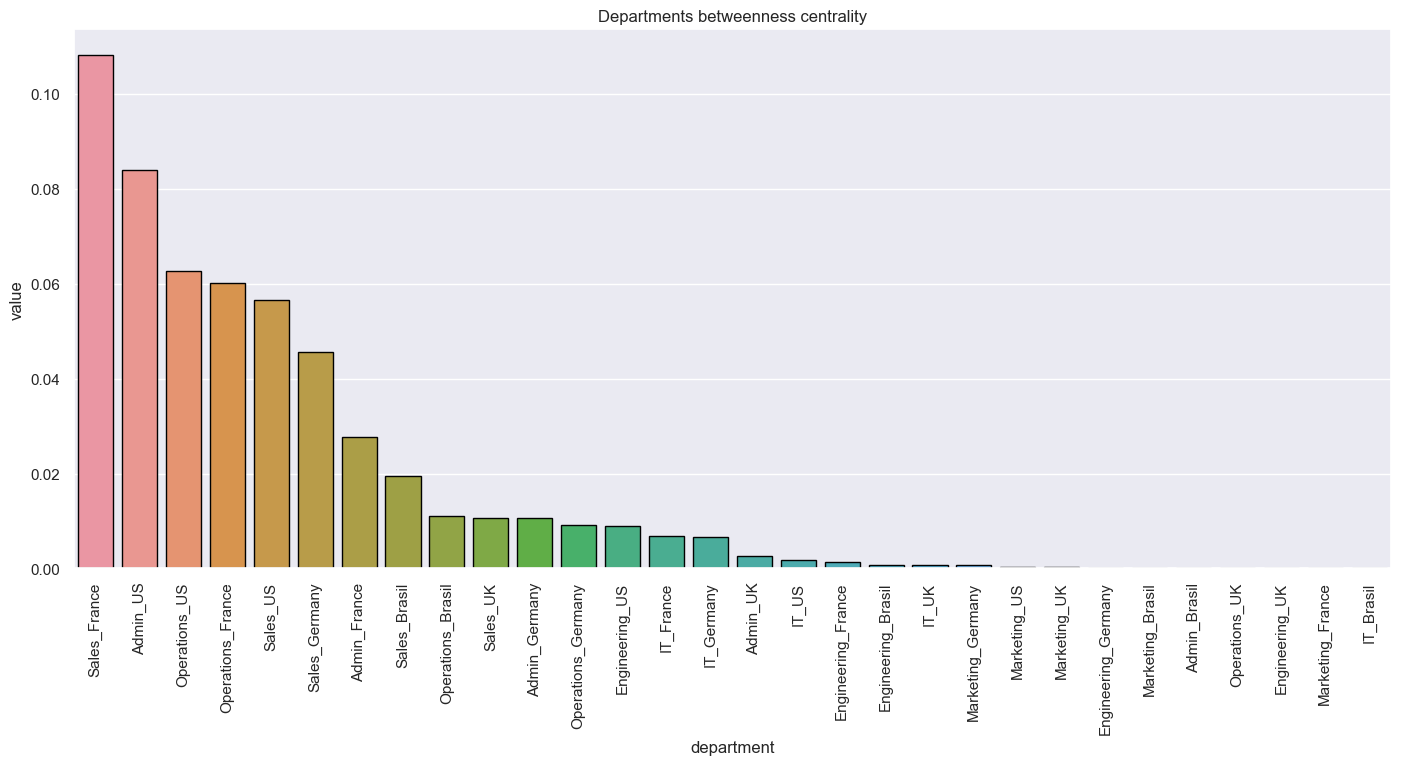

In [13]:
bc = pd.DataFrame({'department' : nx.betweenness_centrality(G).keys() , 'value' : nx.betweenness_centrality(G).values()})
t_plot = bc.sort_values(by='value' , ascending=False)

with sns.plotting_context('notebook'):
    sns.set_style('darkgrid')
    plt.figure(figsize=(17,7))
    sns.barplot(x='department' , y='value' , data=t_plot , edgecolor='black')
    plt.xticks(rotation = 90)
    plt.title('Departments betweenness centrality')
    plt.show()

## Influential employees : 

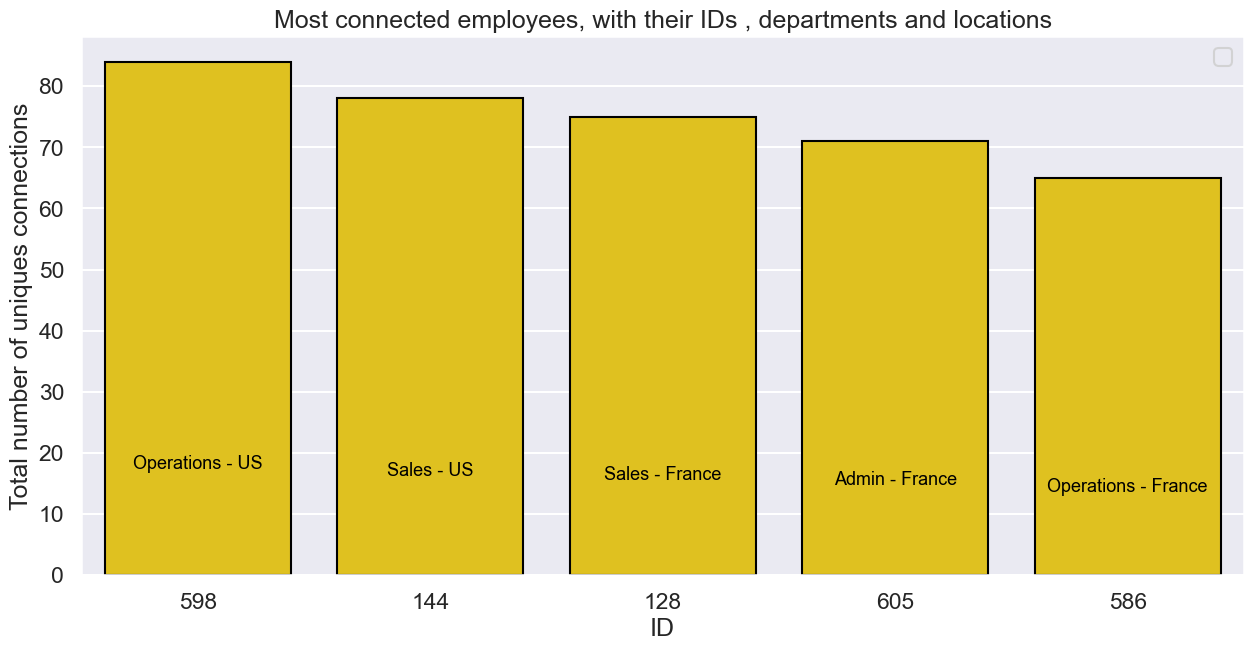

In [14]:
# Function to add text in the bottom of the bar
def autolabel_center(rects , ax , to_plot): 
    for i in range(len(rects)):
        height = rects[i].get_height()
        ax.text(rects[i].get_x() + rects[i].get_width() / 2, 0.2 * height,to_plot[i]\
             , ha='center', va='bottom', color='black' , fontsize=13)
        

best_net = messages.groupby(['sender' , 'receiver']).size().reset_index()
by_send = best_net.groupby('sender' , as_index=False)[0].count().sort_values(by=0 , ascending=False)
by_receiv = best_net.groupby('receiver' , as_index=False)[0].count().sort_values(by=0 , ascending=False)
by_send.columns = ['ID' , 'count']
by_receiv.columns = ['ID' , 'count']
best_conn = by_send.merge(by_receiv , on='ID' , how='inner' , suffixes=['_sent' , '_received'])
best_conn['total'] = best_conn['count_sent'] + best_conn['count_received']
most_connected_empl = best_conn.nlargest(columns='total' , n=5)

dep_loc = []
for id in most_connected_empl['ID']:
    dep_loc.append(employees[employees['id'] == id][['department' , 'location']].values)
    
cleanned_dep_loc = []
for vals in dep_loc:
    cleanned_dep_loc.append(' - '.join(vals[0]))
    

with sns.plotting_context('talk'):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(data=most_connected_empl , x=most_connected_empl['ID'] , y=most_connected_empl['total'] , color='gold' , edgecolor='black' , order=most_connected_empl.sort_values(by='total' , ascending=False)['ID'])
    autolabel_center(ax.patches , ax , cleanned_dep_loc)
    plt.xlabel('ID')
    plt.ylabel('Total number of uniques connections')
    plt.title('Most connected employees, with their IDs , departments and locations')
    plt.legend()
    plt.show()

## Active and inactive departments : 

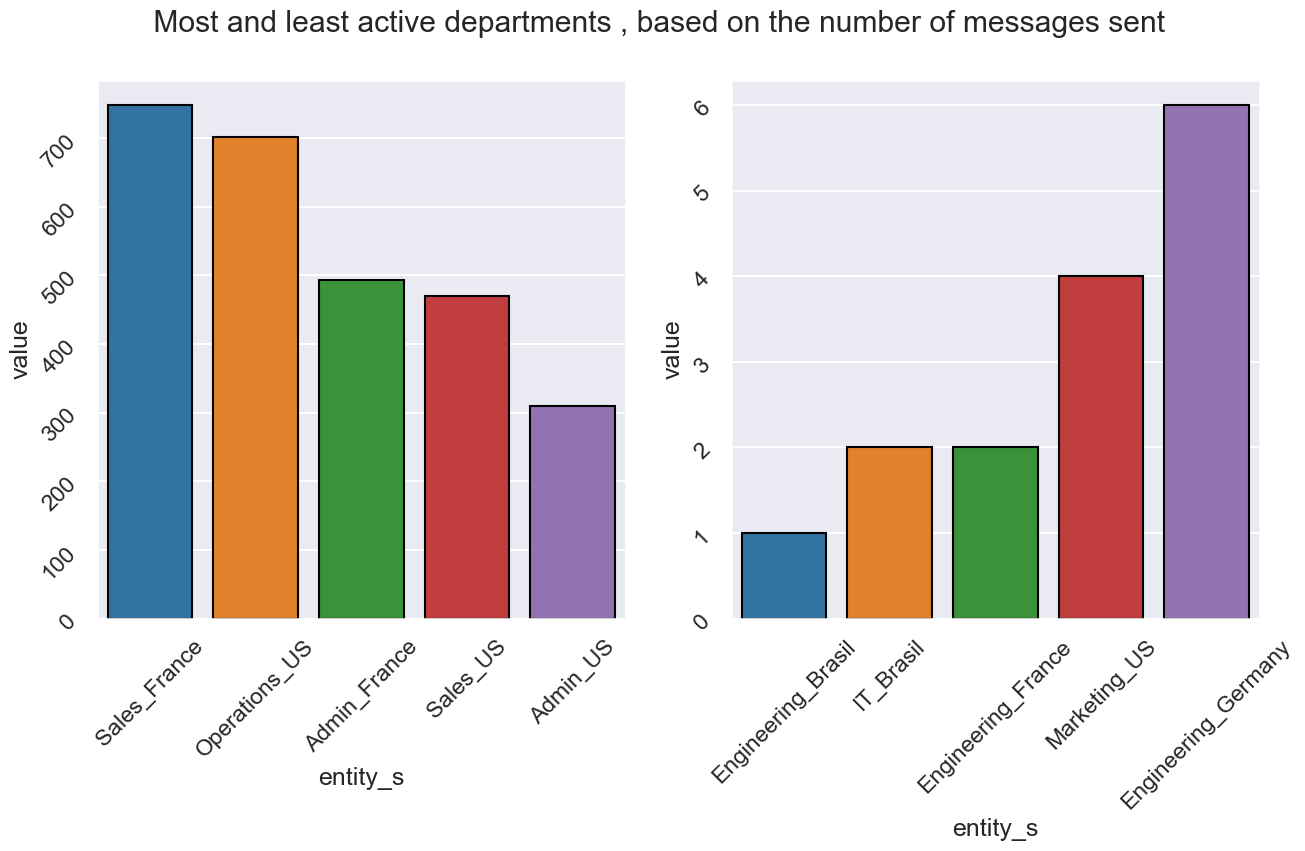

In [15]:
most_active = merged.groupby('entity_s' , as_index=False)['value'].sum().sort_values(by=['value'] , ascending=False).nlargest(n=5 , columns='value')
least_active = merged.groupby('entity_s' , as_index=False)['value'].sum().sort_values(by=['value']).head()

with sns.plotting_context('talk'):
    fig , (ax1 , ax2) = plt.subplots(1,2,figsize=(15,7))
    sns.barplot(data=most_active , x='entity_s' , y='value' , ax=ax1 , edgecolor='black')
    ax1.tick_params(rotation=45)
    sns.barplot(data=least_active , x='entity_s' , y='value' , ax=ax2 , edgecolor='black')
    ax2.tick_params(rotation=45)
    fig.suptitle(' Most and least active departments , based on the number of messages sent ')
    plt.show()

## Communications by departments : 

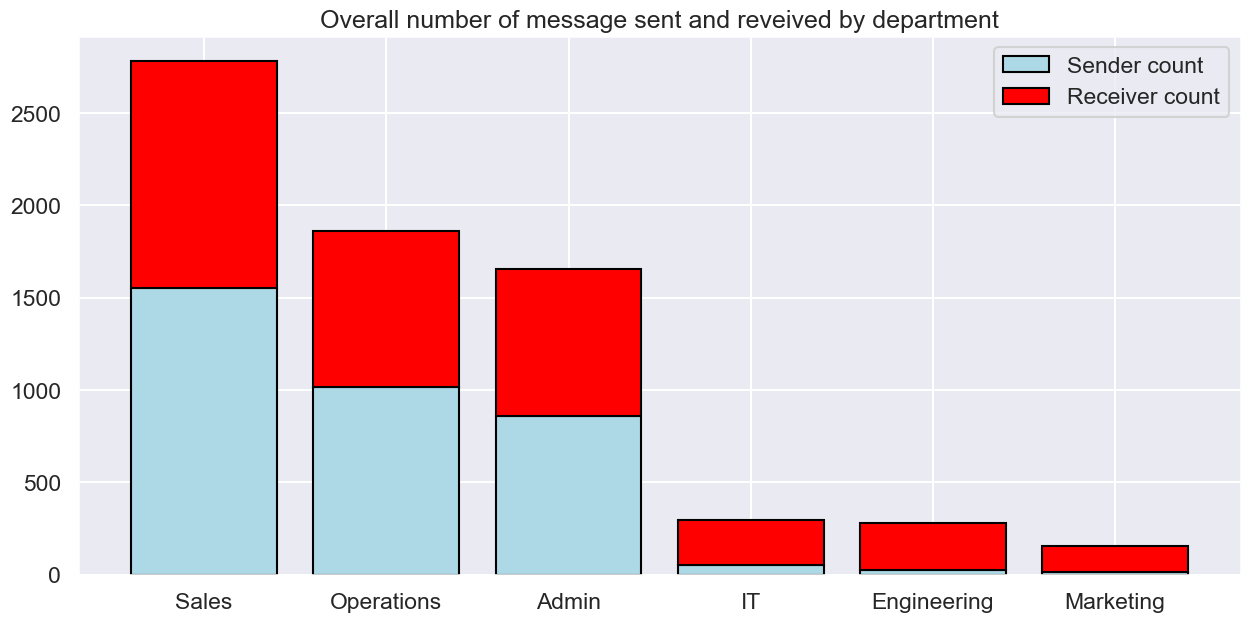

In [16]:
sender_count = pd.DataFrame(messages.merge(employees , left_on='sender' , right_on='id').groupby('department')['sender'].count())
receiver_count = pd.DataFrame(messages.merge(employees , left_on='receiver' , right_on='id').groupby('department')['receiver'].count())
sender_count['receiver'] = receiver_count['receiver']
sender_count['total'] = sender_count['sender'] + sender_count['receiver']
sender_count = sender_count.sort_values(by='total' , ascending=False)

with sns.plotting_context('talk'):
    plt.figure(figsize=(15,7))
    plt.bar(sender_count.index , sender_count['sender'] , color='lightblue' , edgecolor='black' , label='Sender count')
    plt.legend()
    plt.bar(sender_count.index , sender_count['receiver'] , bottom=sender_count['sender'], color='red' , edgecolor='black' , label='Receiver count')
    plt.legend()
    plt.title('Overall number of message sent and reveived by department')
    plt.show()